# Nonlinear Elasticity in a multipatch domain


In [1]:
%pylab inline
import scipy
import itertools

from pyiga import bspline, assemble, vform, geometry, vis, solvers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# assemble matrix
from scipy.sparse import coo_matrix, block_diag, bmat
from scipy.sparse import bsr_matrix

from geo_annulus import *
#from multipatch_block_handler import *
from plots import *
from ass_nonlin_el import *
from solver import *
from line_search import *


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
 no MKL


In [2]:
p = 3  # spline degree 
x_el= 48# 96 #48 #24
y_el= 8 #16 #4
#n_el = (y_el, x_el)#number of elements in y/x direction
n_el = (x_el, y_el) #  isotropic material
# displacement space: degree p,   continuity p-1
multi= 3
kvs_u = tuple(bspline.make_knots(p, 0.0, 1.0, n, mult=multi) for n in n_el) # or : mult=2
#m_u = tuple(kv.numdofs for kv in kvs_u)


In [3]:
r_in = 1.93 #mm
r_out = 2.25 #mm

geos = geo_annulus(r_in, r_out)

In [4]:
patches_u = [(kvs_u, g) for g in geos]

# Here we auto-detect the interfaces between the patches.
MP_u = assemble.Multipatch(patches_u, automatch=True)

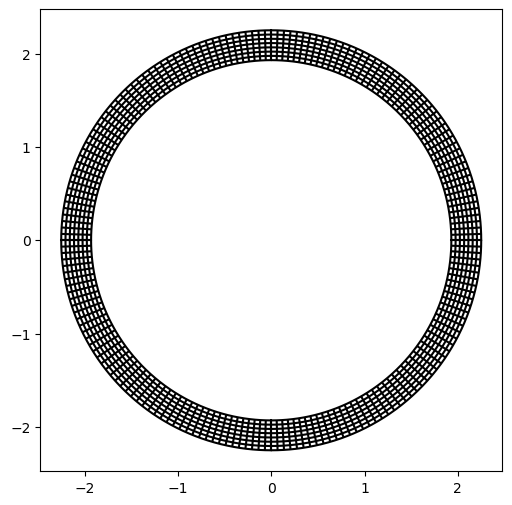

In [5]:

fig, ax = plt.subplots(figsize=(8,6))
for g in geos:
    vis.plot_geo(g, gridx=np.linspace(0, 1, x_el), gridy=np.linspace(0, 1, y_el))
ax.axis('scaled');

In [6]:
## set blocks for x and y component

# Multipatch objects for all variables
MP_block = multipatch_block_handler( [MP_u, MP_u] )


In [7]:
# source term f 
def f(x, y): return (0.0, 0.0)

#Neumann BC
#def gN(x, y): return (x, -y)  #outer pressure
def gN(x, y): 
    return (x/r_in*l_val, y/r_in*l_val)  #inner  pressure, normalized vector

# define Dirichlet boundary function 
def g_zero(x, y): return (0.0, 0.0)


# Robin BC
def g_robin(x, y): 
    return 0 # scalar value
    

In [8]:

# set up Dirichlet boundary conditions
bc = MP_block.compute_dirichlet_bcs([
    (1, 'right', g_zero ) 
])


In [9]:
# define constant spline functions for integration
kvs_j = tuple(bspline.make_knots(0, 0.0, 1.0, n, mult=multi) for n in n_el) # constant basis vector for integration

In [10]:
M = ass_mass(MP_block)
Minv = make_solver(M)

use SuperLU


In [11]:
#incremental loading
maxload = 2.666e-3 #6.666e-3 #5.332e-3 #2.666e-3  #6e-4 #1e-3#1.5e-3 # for Dirichlet #1e3# for Robin
nsteps= 3
loading= np.linspace(maxload/nsteps, maxload, nsteps)


In [12]:
# No Robin-bdc
robin_data = None

In [13]:
def J(u):
    return ass_energy(u, MP_block, kvs_j, neu_data)


def grad_J(u):
    return -ass_rhs(u, MP_block, neu_data)


In [14]:
len(loading)

3

Compiling C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\mod400c8400c17eeecb.pyx because it changed.
[1/1] Cythonizing C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\mod400c8400c17eeecb.pyx


Compiling C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\modc7d17520b69665b4.pyx because it changed.
[1/1] Cythonizing C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\modc7d17520b69665b4.pyx
Residual0 = 0.033292529211977395
Energy0   = 0.0
use SuperLU
Residual  = 0.25713541310387206
Energy    = -0.004096404410894077
Error= 0.07119434863628782


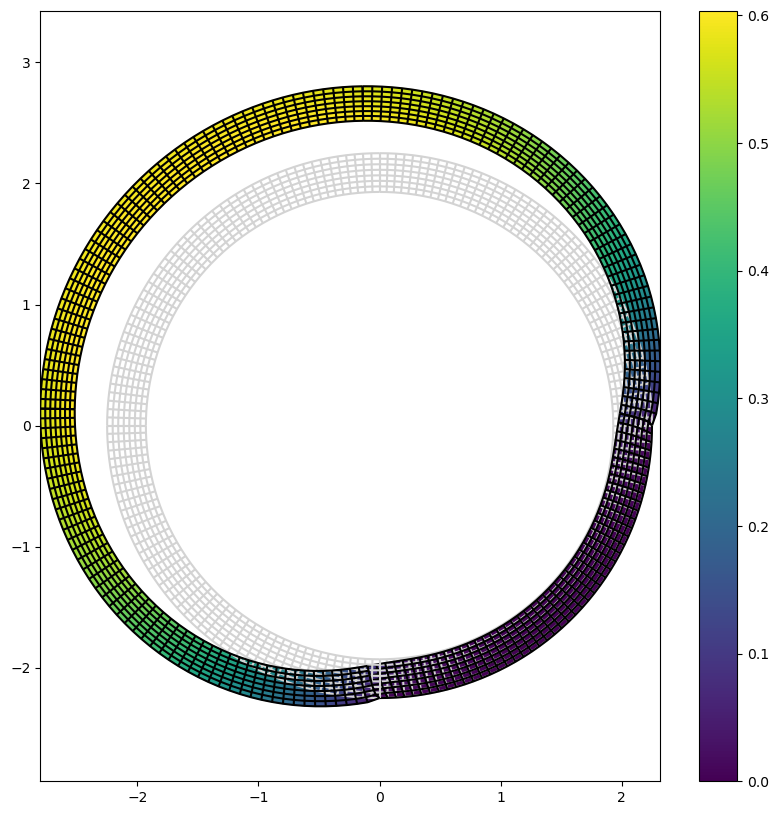

In [15]:
# solve linearized system #Robin instead of Dirichlet, + Neumann force (inner pressure)
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]

#initial value
u= np.zeros(dd)
solution= []

# set Neumann boundary force (via incremental loading) 

### Linear elasticity for largest loading
l_val = loading[-1] # take last loading value
neu_data = [(0,'left',gN, l_val), (1,'left',gN, l_val), (2,'left',gN, l_val), (3,'left',gN, l_val)] # set neumann

### first iteration ###
A, b = ass_nonlinsystem(u, MP_block, neu_data) # without Robin-matrix

LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
rhs= LS.complete(LS.b)
r0 = np.transpose(rhs).dot(Minv.dot(rhs)) #L2-norm
print('Residual0 =', r0)
print('Energy0   =', J(u))

#u_d = make_solver_orig(A, symmetric=True, spd=True).dot(b) 
u_d = make_solver(LS.A).dot(LS.b) 
u_d = LS.complete(u_d)
u += u_d

# new solution
A, b = ass_nonlinsystem(u, MP_block, neu_data) # without Robin-matrix
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
rhs= LS.complete(LS.b)
r = np.transpose(rhs).dot(Minv.dot(rhs)) #L2-norm
print('Residual  =', r)
print('Energy    =', J(u))

w= np.inner(np.transpose(u_d),rhs)
err = np.sqrt(np.abs(w))
print('Error=', err)

###-----------------###--------------------###
solution = [LS.restrict(u)]
# norm of delta u in first step
normed_du0= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
###----------------###---------------------###

# print deformation plot (after first iteration)
get_defplot(u, patches_u, kvs_u, MP_u, n_el)

In [ ]:
get_defplotPP(u, patches_u, kvs_u, MP_u, n_el, r_in, r_out)

 
 
 1. loading: 0.0008886666666666666 

Residual = 0.0036991699124419328
Energy   = 0.0
1
use SuperLU
Error= 0.035515321775739545
 
 
 2. loading: 0.0017773333333333335 

Residual = 0.008513077124264752
Energy   = -0.0018416676141436114
1
use SuperLU
Error= 0.029083698720031578
 
 
 3. loading: 0.002666 

Residual = 0.007477144576261875
Energy   = -0.004436716296149489
1
use SuperLU
Error= 0.028809280243111458
Residual = 0.0018244548133726616
Energy   = -0.004837421016277863
use SuperLU
Error= 0.0022890065038929366
1
Residual = 0.0001168750291692439
Energy   = -0.004840159259086967
use SuperLU
Error= 0.00047513190229253355
2
Residual = 2.8130972700660842e-05
Energy   = -0.004840290710203541
use SuperLU
Error= 0.0001693162754939566
3
Residual = 5.342310732095742e-07
Energy   = -0.004840306358524952
use SuperLU
Error= 2.5630524086688015e-05
4
Residual = 3.989777350563993e-10
Energy   = -0.004840306697822706
use SuperLU
Error= 6.406697219335506e-07
5
Residual = 1.5080024280341056e-16
Ene

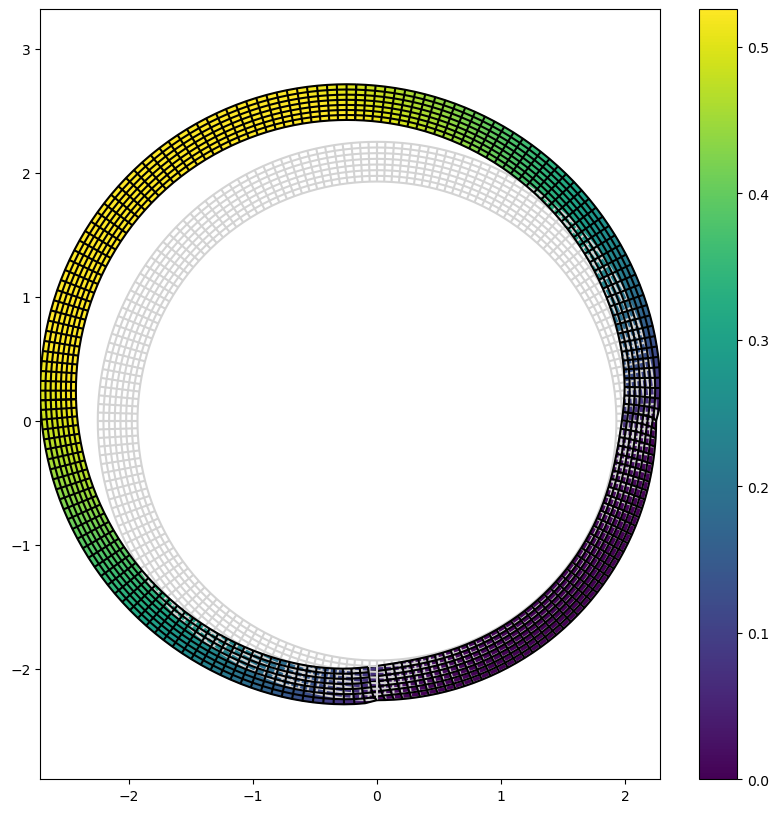

In [16]:
# solve linearized variational problem - iterative, without line-search

#initial value
u= np.zeros(dd)

max_err = 1e-11

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []


# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    l_val = loading[t]
    neu_data = [(0,'left',gN, l_val), (1,'left',gN, l_val), (2,'left',gN, l_val), (3,'left',gN, l_val)] # set neumann

    count = 0
    while count <len(loading)-2:
        A, b = ass_nonlinsystem(u, MP_block, neu_data)
        LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
        rhs= LS.complete(LS.b)
        r = np.transpose(rhs).dot(Minv.dot(rhs)) #L2-norm
        print('Residual =',r)
        print('Energy   =',J(u))
        
        count+=1
        print(count)
         # # solve system # #
        #u_d = make_solver(A).dot(b) 
        u_d = make_solver(LS.A).dot(LS.b)
        u_d = LS.complete(u_d)
        u += u_d   
        
        w= np.inner(np.transpose(u_d),rhs)
        err = np.sqrt(np.abs(w))
        print('Error=', err)

        ud_array.append(u_d)
        normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = normed_du # times alpha
        stepsizes.append(stepsize_du)
    iter_counts.append(count)
    count=0

while True:
    A, b = ass_nonlinsystem(u, MP_block, neu_data)
    LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
    rhs= LS.complete(LS.b)
    r = np.transpose(rhs).dot(Minv.dot(rhs)) #L2-norm
    print('Residual =',r)
    print('Energy   =',J(u))
    
    # # solve system # #
    #u_d = make_solver(A).dot(b) 
    u_d = make_solver(LS.A).dot(LS.b)
    u_d = LS.complete(u_d)
    
    w= np.inner(np.transpose(u_d),rhs)
    err = np.sqrt(np.abs(w))
    print('Error=', err)
    
    if abs(err) < max_err:
        break
    elif count == 20:
        break
    # count only when new solution is computed!
    count+=1
    print(count)
    # update solution
    u += u_d   
    
    #----------------------------------------------------#
    ud_array.append(u_d)
    normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
    #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
    stepsize_du = normed_du # times alpha
    stepsizes.append(stepsize_du)
    #---------------------------------------------------#

ud_array.append(u_d) 
print('u= ' , u)
solutions.append(LS.restrict(u))
iter_counts.append(count)
        
# print deformation plot (after first iteration)
get_defplot(u, patches_u, kvs_u, MP_u, n_el)

In [ ]:
get_defplotPP(u, patches_u, kvs_u, MP_u, n_el, r_in, r_out)

Compiling /home/hilbert/heigl/.cache/pyiga/modules/mod49e190b2288172d2.pyx because it changed.
[1/1] Cythonizing /home/hilbert/heigl/.cache/pyiga/modules/mod49e190b2288172d2.pyx


In file included from /home/hilbert/heigl/anaconda/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969,
                 from /home/hilbert/heigl/anaconda/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/hilbert/heigl/anaconda/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /home/hilbert/heigl/.cache/pyiga/modules/mod49e190b2288172d2.c:776:
/home/hilbert/heigl/anaconda/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


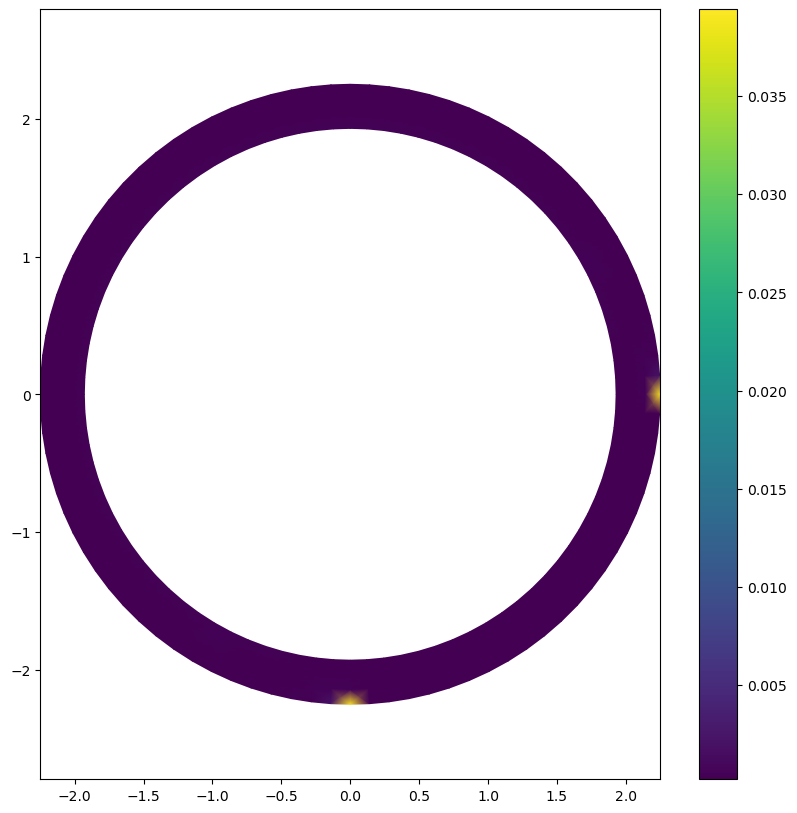

In [19]:
get_defplot_scalar(cauchystress(u, MP_block), patches_u, kvs_u, MP_u, n_el, geos)

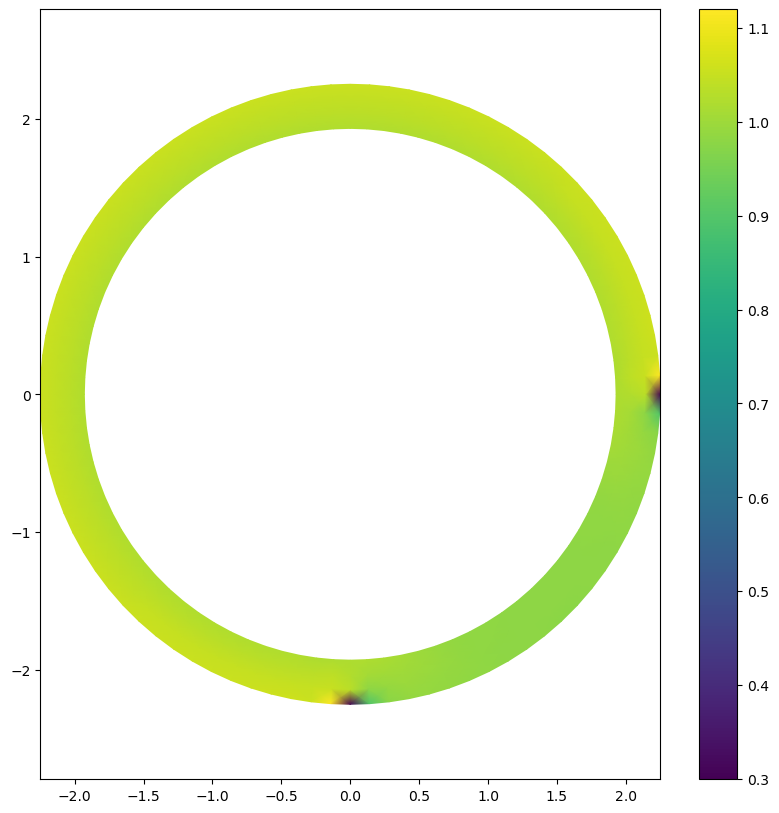

In [20]:
get_defplot_scalar(local_vol(u, MP_block), patches_u, kvs_u, MP_u, n_el, geos)

In [21]:
cs =cauchystress(u, MP_block)
print(max(cs))

0.04147663163534711


In [22]:
print(np.shape(cs))

(3744,)


In [23]:
cs

array([0.00023491, 0.00022954, 0.00021031, ..., 0.00025944, 0.00025117,
       0.00024371])

In [24]:
def get_defplot_evalp(cs, vol, patches_u, kvs_u, MP_u, n_el):

    """Split solution vector into displacement components."""
    cs_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ cs)
               for p in range(len(patches_u))]
    
    v_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ vol)
               for p in range(len(patches_u))]
    
    # evaluate displacement (and "pressure") over a grid in the parameter domain
    # grid variables
    x_el = n_el[0]
    y_el = n_el[1]
    
    xgrid=np.linspace(0, 1, x_el)
    ygrid=np.linspace(0, 1, y_el)
    xygrid = (xgrid, ygrid)
    vrange= None
    count =0

    fig, ax = plt.subplots(figsize= (10,10))
    
    # visualization per patch
    for (cs_func, v_func,(kvs, geo)) in zip(cs_funcs, v_funcs, patches_u): #u_funcs 
        stress = cs_func.grid_eval(xygrid) #x-value # cauchy-stress
        max_cs = max(stress.ravel())
        #print(shape(stress))
        volume = v_func.grid_eval(xygrid) # volume
        G = geo.grid_eval(xygrid)
        # evaluate on undeformed grid
        plt.plot(G[0, y_el-1, 0], G[0, y_el-1, 1] , 'co') # outer radius
        plt.plot(G[0, 0, 0], G[0, 0, 1] , 'mo') # inner radius
        
        print('\n patch:', count)
        print('cauchystress_inner= {}'.format(stress[0, 0]))
        print('cauchystress_outer= {}'.format(stress[0, y_el-1]))
        print('max_stress= ', max_cs)
        if count==2:
            plt.plot(G[0, y_el-1, 0], G[0, y_el-1, 1] , 'go') # outer radius
            
        
        if count==1:
            #plt.plot(G[0, y_el-1, 0], G[0, y_el-1, 1] , 'go') # outer radius
            #plt.plot(G[0, 0, 0], G[0, 0, 1] , 'go') # inner radius
            plt.plot(G[x_el-2, y_el-1, 0], G[x_el-2, y_el-1, 1] , 'bo') # outer radius
            plt.plot(G[x_el-2, 0, 0], G[x_el-2, 0, 1] , 'ro') # inner radius
            print('cauchystress_inner1= {}'.format(stress[x_el-2, 0]))
            print('cauchystress_outer1= {}'.format(stress[x_el-2, y_el-1]))
        
        
        print('volume_inner= {}'.format(volume[0, 0]))
        print('volume_outer= {}'.format(volume[0, y_el-1]))

        C  = stress
        if vrange is None:
            #vrange = (C.min(), C.max())
            vrange = (0.0, 1.5e-3)
            
        plt.pcolormesh(G[..., 0], G[..., 1], C, shading='gouraud', cmap='viridis', vmin = 0.0, vmax = 1.5e-3)
                                   # vmin=vrange[0], vmax=vrange[1])
        count+=1
        
    plt.colorbar();
    plt.axis('equal')


 patch: 0
cauchystress_inner= 0.00025140604919629626
cauchystress_outer= 0.039420453904495986
max_stress=  0.039420453904495986
volume_inner= 1.0206006996967312
volume_outer= 0.29952036005885413

 patch: 1
cauchystress_inner= 0.00025140604919629615
cauchystress_outer= 0.03942045390449608
max_stress=  0.03942045390449608
cauchystress_inner1= 0.00023980917928877443
cauchystress_outer1= -0.0026754175785727733
volume_inner= 1.0206006996967312
volume_outer= 0.29952036005883864

 patch: 2
cauchystress_inner= 0.00039551399156627186
cauchystress_outer= 0.000243706333703003
max_stress=  0.03942045390449608
volume_inner= 1.022519490700669
volume_outer= 1.053068961872435

 patch: 3
cauchystress_inner= 0.0003955139915662614
cauchystress_outer= 0.00024370633370300536
max_stress=  0.00039551399156627186
volume_inner= 1.022519490700688
volume_outer= 1.0530689618724203


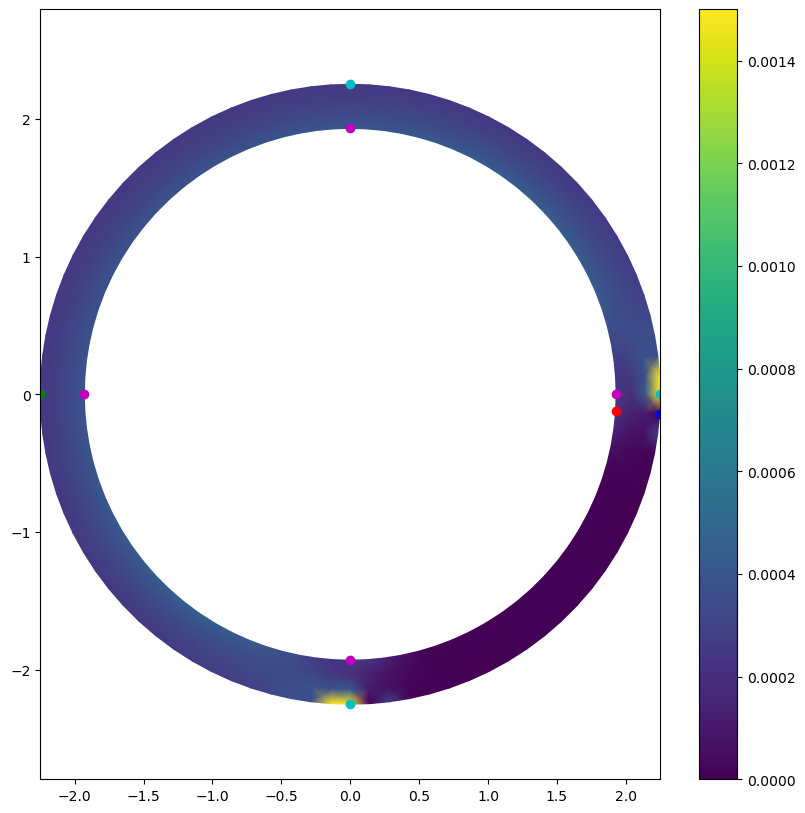

In [25]:
get_defplot_evalp(cauchystress(u, MP_block), local_vol(u, MP_block), patches_u, kvs_u, MP_u, n_el)

In [26]:
solutions

[array([0.05753493, 0.05443156, 0.05154032, ..., 0.16897144, 0.16823955,
        0.16750513])]

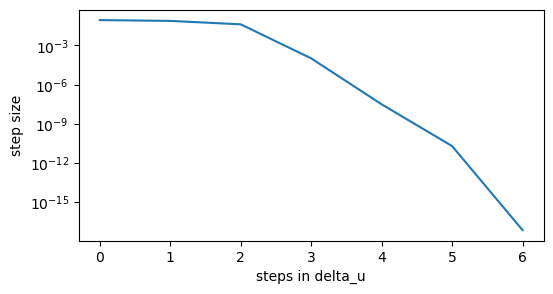

In [27]:
# plot history of step sizes
figsize(6,3)
fig, ax = plt.subplots()
yscale('log')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(stepsizes);
xlabel('steps in delta_u'); ylabel('step size');

In [28]:
iter_counts

[1, 1, 1, 4]

In [29]:
sum(iter_counts)

7

In [ ]:
figsize(6,3)
fig, ax= plt.subplots()

s_cts= shape(iter_counts)[0]
plot(range(s_cts), iter_counts)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title(' Number of iterations over loading process');
xlabel('Loading'); ylabel('Number of iterations');

In [ ]:
# solve linearized variational problem - iterative, without loading

#initial value
u= np.zeros(dd)

max_err = 1e-11

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []

# without incremental loading
print(" \n \n max. loading: {} \n".format(loading[-1]))

# set Neumann data via incremental loading
l_val = loading[-1]
neu_data = [(0,'left',gN, l_val), (1,'left',gN, l_val), (2,'left',gN, l_val), (3,'left',gN, l_val)] # set neumann

count = 0

while True:
    A, b = ass_nonlinsystem(u, MP_block, neu_data)
    LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
    rhs= LS.complete(LS.b)
    r = np.transpose(rhs).dot(Minv.dot(rhs)) #L2-norm
    print('Residual =',r)
    print('Energy   =',J(u))
    
    # # solve system # #
    #u_d = make_solver(A).dot(b) 
    u_d = make_solver(LS.A).dot(LS.b)
    u_d = LS.complete(u_d)
    
    w= np.inner(np.transpose(u_d),rhs)
    err = np.sqrt(np.abs(w))
    print('Error=', err)
    
    if abs(err) < max_err:
        break
    elif count == 30:
        break
    
    count+=1
    print(count)
    # update solution
    u += u_d   
    
    #----------------------------------------------------#
    ud_array.append(u_d)
    normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
    #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
    stepsize_du = normed_du # times alpha
    stepsizes.append(stepsize_du)
    #iter_counts.append(count)
    #---------------------------------------------------#

ud_array.append(u_d) 
print('u= ' , u)
solutions.append(LS.restrict(u))
iter_counts.append(count)
        
# print deformation plot (after first iteration)
get_defplot(u, patches_u, kvs_u, MP_u, n_el)

In [ ]:
sum(iter_counts)

In [ ]:
# solve linearized variational problem - iterative, without line-search

#initial value
u= np.zeros(dd)

max_err = 1e-11

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []


# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    l_val = loading[t]
    neu_data = [(0,'left',gN, l_val), (1,'left',gN, l_val), (2,'left',gN, l_val), (3,'left',gN, l_val)] # set neumann

    count = 0
    while True:

        A, b = ass_nonlinsystem(u, MP_block, neu_data)
        LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
        rhs= LS.complete(LS.b)
        r = np.transpose(rhs).dot(Minv.dot(rhs)) #L2-norm
        print('Residual =',r)
        print('Energy   =',J(u))
            

        # # solve system # #
        #u_d = make_solver(A).dot(b) 
        u_d = make_solver(LS.A).dot(LS.b)
        u_d = LS.complete(u_d)
             
        w= np.inner(np.transpose(u_d),b)
        err = np.sqrt(np.abs(w))
        print('Error=', err)

        #----------------------------------------------------#
        ud_array.append(u_d)
        normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = normed_du # times alpha
        stepsizes.append(stepsize_du)
        #---------------------------------------------------#

        if err < max_err:
            break
        elif count == 20:
            break
            
        # update solution
        u += u_d 
        count+=1
        print(count)
        
    #
    ud_array.append(u_d) 
    print('u= ' , u)
    solutions.append(LS.restrict(u))
    iter_counts.append(count)
        
# print deformation plot (after first iteration)
get_defplot(u, patches_u, kvs_u, MP_u, n_el)

In [ ]:
sum(iter_counts)

In [ ]:
s_sol= shape(solutions)[0]

In [ ]:
s_sol

In [ ]:
plt.clf()

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection

plt.rcParams['animation.html'] = 'html5'
plt.rcParams['font.size'] = 18

fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')
res=(50,70)
#vrange=(0.0, 1.5e-3)

s_sol= shape(solutions)[0]
ims = []
ar= np.linspace(1,2, s_sol)
factor = 1


#fields = list(ud_array)
fields = list(solutions)

for tt in range(s_sol):
    u = LS.complete(fields[tt])
    #u = fields[tt]
    factor = ar[tt] # choose factor for deformation plot
    vrange = None
    ims_q = []
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:]

    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
            for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
            for p in range(len(patches_u))]
    plt.ioff()
    
    # visualization per patch
    for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches_u): #u_funcs 
        im_q=[]
        grd = tuple(np.linspace(s[0], s[1], r) for (s, r) in zip(geo.support, res))
        XY = geo.grid_eval(grd)
        dis1 = u1_func.grid_eval(grd) #x-value
        dis2 = u2_func.grid_eval(grd) #y-value
        dis = np.stack((dis1,dis2), axis=-1)
        C = np.sqrt(np.power(dis[..., 0], 2) + np.power(dis[..., 1], 2))
        if vrange is None:
            #vrange = (0.0, 1.5e-3)
            vrange = (C.min(), C.max())
        im_q = plt.pcolormesh(XY[..., 0] + factor*dis[..., 0], XY[..., 1] + factor*dis[..., 1], C, shading='gouraud', cmap='viridis', 
                                    vmin=vrange[0], vmax=vrange[1], axes=ax) # shading for smoothing
        
        im_q.set_array(C.ravel()) 
        ims_q.append(im_q) 
    
    ims.append(ims_q)
    #print(shape(ims))
#print(ims[0])
    
#fig.colorbar(im_q, ax=ax);
colorbar();
ani = animation.ArtistAnimation(fig, ims, blit=True, repeat= False) # repeat_delay=2000



#ani.to_html5_video()


Writer = animation.writers['ffmpeg']
writer = Writer(fps=500, metadata=dict(artist='Me'))
vid = ani.to_html5_video()

#writervideo = animation.FFMpegWriter(fps=50)
#ani.save('Dir2d_p3m1_1.mp4', writer=writervideo)


plt.close()



In [ ]:
ani

In [ ]:
vol_ratio= global_vol (u, MP_block, kvs_j)

In [ ]:
vol_ratio

In [ ]:
# refine

In [ ]:
kvs_ref= tuple(bspline.make_knots(p, 0.0, 1.0, n, mult=multi).refine() for n in n_el)

In [ ]:
# first Piols Kirchhoff - Tensor
Mu= 27.9 * 1e-3 # N/mm²
# Plane Stress assumption:
Lam = 53.9475 * 1e-3  # N/mm²

def sigma_rhs(u_p, kvs_ux, kvs_ref, geo_ux, X):
    dis = get_components(X.T @ u_p, kvs_ux)
    e_term = '(.5*( grad(dis).T + grad(dis) + (grad(dis).T).dot(grad(dis)) ))'
    f_term = '( idmat + grad(dis))'
    sigma_term = f'(1/det({f_term}) *({f_term}).dot( Lam*tr({e_term})*idmat + 2*Mu* {e_term} ).dot({f_term}.T))'
    return assemble.assemble(f' inner({sigma_term},{sigma_term})*aux_s * dx',
                              kvs_ref, bfuns=[('aux_s',1)], geo=geo_ux, dis=dis, Lam=Lam, Mu=Mu, idmat=np.identity(2)).ravel()

def cauchy_mass(kvs_ux, geo_ux):
    return assemble.assemble('s* aux_s*dx', kvs_ux, bfuns=[('s', 1), ('aux_s', 1)], geo=geo_ux)
    

In [ ]:
# assamble cauchy-stress tensor
def cauchystress(u, MP_block):
    first = True
    def f(x, y): return (0.0, 0.0)

    for p in range(MP_block.numpatches):
        
        X = MP_block.multi_patches[0].patch_to_global(p)
        #print('shape X: ', shape(X))
        Xvec = MP_block.patch_to_global(p)
        

        # All the geometries are supposed to be equal; also kvs_ux and kvs_uy are equal
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]  # kvs_uy, geo_uy
        # refined knot vectors
        kvs_refx= kvs_ux[0].refine()
        kvs_refy= kvs_ux[1].refine()
        kvs_ref=(kvs_refx, kvs_refy)
        patches_ref = [(kvs_ref, g) for g in geos]
        MP_ref = assemble.Multipatch(patches_ref, automatch=True)
        MP_blockref = multipatch_block_handler( [MP_ref, MP_ref] )
        X = MP_blockref.multi_patches[0].patch_to_global(p)
       
       
        S_B = sigma_rhs(u, kvs_ux, kvs_ref, geo_ux, Xvec)
        #print('S_B:',shape(S_B))
      
        C_x = cauchy_mass(kvs_ref, geo_ux)
        #print('C_x:',shape(C_x))

        
        if first:
            C = X @ C_x @ X.T
            SB = X @ S_B 
            first = False
        else:
            C += X @ C_x @ X.T
            SB += X @ S_B 

    return make_solver(C).dot(SB) 

In [ ]:
def get_defplotS(u, patches_u, kvs_ref, MP_u, n_el):
    ## use refined knot vectors
    patches_ref = [(kvs_ref, g) for g in geos]
    MP_ref = assemble.Multipatch(patches_ref, automatch=True)
    
    """Split solution vector into displacement components."""
    u_funcs = [geometry.BSplineFunc(kvs_ref, MP_ref.global_to_patch(p) @ u)
               for p in range(len(patches_ref))]
    
    # evaluate displacement (and "pressure") over a grid in the parameter domain
    # grid variables
    x_el = n_el[0]
    y_el = n_el[1]
    
    xgrid=np.linspace(0, 1, x_el)
    ygrid=np.linspace(0, 1, y_el)
    xygrid = (xgrid, ygrid)
    vrange= None

    fig, ax = plt.subplots(figsize= (10,10))
    
    # visualization per patch
    for (u_func,(kvs, geo)) in zip(u_funcs, patches_u): #u_funcs 
        dis = u_func.grid_eval(xygrid) #x-value
        G = geo.grid_eval(xygrid)
        #plot_grid(G[..., 0], G[..., 1], ax=ax, color="lightgrey")
        #plot_grid(G[..., 0] + dis[..., 0], G[..., 1] + dis[..., 1], ax=ax, color="black")
        #C = np.sqrt(np.power(dis[..., 0], 2) + np.power(dis[..., 1], 2))
        C  = dis
        if vrange is None:
            vrange = (C.min(), C.max())
            

        plt.pcolormesh(G[..., 0], G[..., 1], C, shading='gouraud', cmap='viridis', 
                                    vmin=vrange[0], vmax=vrange[1])
    plt.colorbar();
    plt.axis('equal')


In [ ]:
get_defplotS(cauchystress(u, MP_block), patches_u, kvs_ref, MP_u, n_el)